<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-1-Data-Preprocessing" data-toc-modified-id="Part-1-Data-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part 1 Data Preprocessing</a></span></li><li><span><a href="#Part-2-Graphs" data-toc-modified-id="Part-2-Graphs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 2 Graphs</a></span></li><li><span><a href="#Part-3-AdaBoost" data-toc-modified-id="Part-3-AdaBoost-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part 3 AdaBoost</a></span></li><li><span><a href="#Part-4-(SVM)" data-toc-modified-id="Part-4-(SVM)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Part 4 (SVM)</a></span><ul class="toc-item"><li><span><a href="#Plotting-Decision-Boundries" data-toc-modified-id="Plotting-Decision-Boundries-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plotting Decision Boundries</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span></li><li><span><a href="#Hard-Voting-Classifiers" data-toc-modified-id="Hard-Voting-Classifiers-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Hard Voting Classifiers</a></span></li><li><span><a href="#Convex-Optimization" data-toc-modified-id="Convex-Optimization-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Convex Optimization</a></span></li></ul></li></ul></div>

## Part 1 Data Preprocessing
Replace all the nan values in "PH" feature using "sulphates" feature. 

In [84]:
import pandas as pd
import math
import warnings
warnings.filterwarnings("ignore")

# load dataset 
dataset_df = pd.read_csv('JuiceQuality.csv')

# quantitication!
dataset_df['quality'] = dataset_df['quality'].map({'low':0, 'high':1})
dataset_df['residual sugar'] = dataset_df['residual sugar'].map({'very_low':-2, 'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['sulphates'] = dataset_df['sulphates'].map({'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['Vit Indx'] = dataset_df['Vit Indx'].map({'very_low':-2, 'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['Type'] = dataset_df['Type'].map({'Lemon_Juice':0, 'Orange_Juice':1})

# fix pH
for iter_, item_ in enumerate(dataset_df['pH']):
    if (math.isnan(item_)):
        dataset_df['pH'][iter_]= round(dataset_df[dataset_df['sulphates']==dataset_df['sulphates'][iter_]].mean()['pH'], 3)

Use Linear Regression to fill out nan values. "A Indx" feature is presumed as a Label and "fixed acidity", "citric acid" and " chlorides" are our features. You can use any of the mentioned features to estimate nan values in Label. 

In [56]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

# X_train :: features with known "A Indx" variable 
# y_train :: "A Indx" variable 

# Extract train and test
local_df = dataset_df[['fixed acidity','citric acid','chlorides','A Indx']]
train_df = local_df[pd.notna(local_df['A Indx'])]
test_df  = local_df[pd.isna(local_df['A Indx'])]
train_df.dropna(inplace=True)
X_train_df = train_df[['fixed acidity','citric acid', 'chlorides']]
y_train = train_df['A Indx']

# Determine the most informative features (aka Feature Selection)
# Method 1 : Correlation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train_df, y_train)
print("--- Correlation based scores --- \n- fixed acidity: {} \n- citric acid: {} \n- chlorides: {}".format(fs.scores_[0], fs.scores_[1], fs.scores_[2]))

# Method 2: Mutual Information Feature Selection
from sklearn.feature_selection import mutual_info_regression
fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train_df, y_train)
print("\n\n--- Mutual Information based scores --- \n- fixed acidity: {} \n- citric acid: {} \n- chlorides: {}".format(fs.scores_[0], fs.scores_[1], fs.scores_[2]))

### According to the scores, we select first 2 features
X_train = X_train_df[['fixed acidity','citric acid']]
X_test = test_df[['fixed acidity','citric acid']]
X_test.dropna(inplace=True)

# Regress
regressor.fit(X_train, y_train)
print("\n--- Train score: {}".format(regressor.score(X_train,y_train)))
y_test_predicted = regressor.predict(X_test)

--- Correlation based scores --- 
- fixed acidity: 176697.85484140943 
- citric acid: 1298.9360868834865 
- chlorides: 525.2599214181943


--- Mutual Information based scores --- 
- fixed acidity: 1.6390555295498848 
- citric acid: 0.14255947392076163 
- chlorides: 0.1338225862060627

--- Train score: 0.9864872427810966


-------- REPORT ----------

#### Feature Selection
There are two popular feature selection techniques that can be used for numerical input data and a numerical target variable. They are:

1. Correlation Statistics: measures the dependency between two random variables or bivariate data
2. Mutual Information Statistics: based on inforamtion theory based concept of entropy

I skip the details, it is only about some messy formula :)


Here, it both of the methods show that fixed acidity and citric acid are more crtitical, so we take advantage of them

-------- REPORT ----------

Use the categorial features like "Vit Indx" to estimate nan values in " A Indx" feature. 

In [82]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# X_train :: encoded "Vit Indx" feature with known "A Indx" variable 

# load dataset 
dataset_df = pd.read_csv('JuiceQuality.csv')
local_df = dataset_df[['sulphates', 'residual sugar', 'Vit Indx', 'A Indx']]
train_df = local_df[pd.notna(local_df['A Indx'])]
train_df.dropna(inplace=True)
test_df  = local_df[pd.isna(local_df['A Indx'])]

X_train = train_df[['sulphates','residual sugar','Vit Indx']]
y_train = train_df['A Indx']
X_test = test_df[['sulphates','residual sugar','Vit Indx']]
X_test.dropna(inplace=True)

# encoding
X_train['sulphates'] = X_train['sulphates'].map({'low':"0,0", 'medium':"0,1", 'high':"1,0", 'very_high':"1,1"})
X_train['Vit Indx'] = X_train['Vit Indx'].map({'very_low':"0,0,0", 'low':"0,0,1", 'medium':"0,1,0", 'high':"0,1,1", 'very_high':"1,0,0"})
X_train['residual sugar'] = X_train['residual sugar'].map({'very_low':"0,0,0", 'low':"0,0,1", 'medium':"0,1,0", 'high':"0,1,1", 'very_high':"1,0,0"})
X_train[['sulph_1','sulph_2']] = X_train['sulphates'].str.split(",",expand=True)
X_train[['vit_idx_1','vit_idx_2','vit_idx_3']] = X_train['Vit Indx'].str.split(",",expand=True)
X_train[['res_sug_1','res_sug_2','res_sug_3']] = X_train['residual sugar'].str.split(",",expand=True)
X_train.drop(['sulphates', 'Vit Indx', 'residual sugar'] , inplace=True, axis=1)

X_test['sulphates'] = X_test['sulphates'].map({'low':"0,0", 'medium':"0,1", 'high':"1,0", 'very_high':"1,1"})
X_test['Vit Indx'] = X_test['Vit Indx'].map({'very_low':"0,0,0", 'low':"0,0,1", 'medium':"0,1,0", 'high':"0,1,1", 'very_high':"1,0,0"})
X_test['residual sugar'] = X_test['residual sugar'].map({'very_low':"0,0,0", 'low':"0,0,1", 'medium':"0,1,0", 'high':"0,1,1", 'very_high':"1,0,0"})
X_test[['res_sug_1','res_sug_2','res_sug_3']] = X_test['residual sugar'].str.split(",",expand=True)
X_test[['vit_idx_1','vit_idx_2','vit_idx_3']] = X_test['Vit Indx'].str.split(",",expand=True)
X_test[['sulph_1','sulph_2']] = X_test['sulphates'].str.split(",",expand=True)
X_test.drop(['sulphates', 'Vit Indx', 'residual sugar'] , inplace=True, axis=1)

regressor.fit(X_train, y_train)
y_test = regressor.predict(X_test)
print("\n--- Train score: {}".format(regressor.score(X_train,y_train)))



--- Train score: 0.10545246585717016


-------- REPORT ----------

Here the result is not satisfying, this is because values are very diperse and have no meaningful dependency 

-------- REPORT ----------


## Part 2 Graphs 
Plot Bar Graph for the "sulphates" feature for high and low quality juice.

------------ Statistics of all rows


,citric acid,A Indx,pH,volatile acidity
count,5279.000000,5279.000000,5279.000000,5279.000000
mean,0.318005,16.043791,3.217375,0.339652
std,0.143791,2.912452,0.160683,0.164340
min,0.000000,7.989156,2.720000,0.080000
25%,0.240000,14.286122,3.110000,0.230000
50%,0.310000,15.476831,3.200000,0.290000
75%,0.390000,17.090391,3.320000,0.400000
max,1.230000,35.336936,4.010000,1.580000


------------ Statistics of * low quality * rows


,citric acid,A Indx,pH,volatile acidity
count,1837.000000,1837.000000,1837.000000,1837.000000
mean,0.304077,16.288893,3.212803,0.397063
std,0.161629,2.877662,0.161460,0.189166
min,0.000000,9.379334,2.740000,0.100000
25%,0.210000,14.481131,3.100000,0.260000
50%,0.300000,15.749720,3.190000,0.340000
75%,0.400000,17.471961,3.310000,0.500000
max,1.000000,35.224130,3.900000,1.580000


------------ Statistics of * high quality * rows


,citric acid,A Indx,pH,volatile acidity
count,3169.000000,3169.000000,3169.000000,3169.000000
mean,0.326308,15.935195,3.218517,0.305879
std,0.130586,2.958956,0.160062,0.137981
min,0.000000,7.989156,2.720000,0.080000
25%,0.270000,14.203869,3.110000,0.210000
50%,0.320000,15.366115,3.210000,0.270000
75%,0.390000,16.865431,3.320000,0.360000
max,1.230000,35.336936,3.900000,1.040000


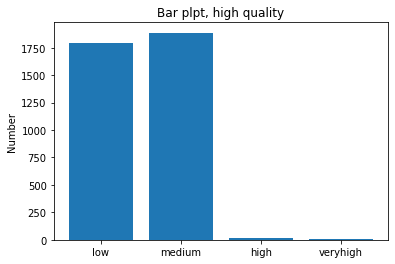

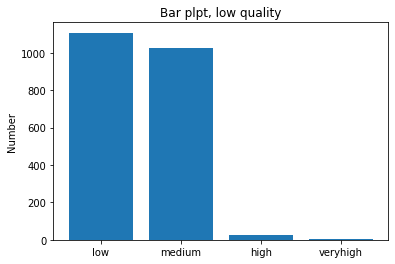

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns

# load dataset 
dataset_df = pd.read_csv('JuiceQuality.csv')

# define axis and labels 
local_df = dataset_df[['citric acid','A Indx','pH','volatile acidity']]
local_df.dropna(inplace=True)

# Numeric Stats
print("------------ Statistics of all rows")
display(local_df.describe())
print("------------ Statistics of * low quality * rows")
display(local_df[dataset_df['quality']=='low'].describe())
print("------------ Statistics of * high quality * rows")
display(local_df[dataset_df['quality']=='high'].describe())

# Bar Plot
local_df = dataset_df[['sulphates','quality']]
## high q - plt
high_df = local_df[local_df['quality'] == 'high']
index = ['low', 'medium', 'high', 'veryhigh']
value = [len(high_df[high_df['sulphates'] == 'low']),len(high_df[high_df['sulphates'] == 'medium']),
         len(high_df[high_df['sulphates'] == 'high']),len(high_df[high_df['sulphates'] == 'very_high'])]
plt.bar(index, value)
plt.title('Bar plpt, high quality')
plt.ylabel('Number')
plt.show()

## low q - sns
low_df = local_df[local_df['quality'] == 'low']
index = ['low', 'medium', 'high', 'veryhigh']
value = [len(low_df[low_df['sulphates'] == 'low']),len(low_df[low_df['sulphates'] == 'medium']),
         len(low_df[low_df['sulphates'] == 'high']),len(low_df[low_df['sulphates'] == 'very_high'])]
plt.bar(index, value)
plt.title('Bar plpt, low quality')
plt.ylabel('Number')
plt.show()


-------- REPORT ----------

volatile acidity:
تفاوت به نسبت بیشتری در این مقدار بین نوشیدنی باکیفیت و بی کیفیت وجود دارد، نوشیدنی با کیفیت، مقدار کمتری از فیچر را دارد

pH:
تفاوت این فیچر، در بین دو گروه ناچیز است ولی نوشیدنی باکیفیت مقدار بیشتری دارد

A Indx:
تفاوت به نسبت قابل توجهی بین دو گروه دیده می شود، مقدار آن برای نوشدنی باکیفیت کمتر است

citric acid:
نوشیدنی باکیفیت، مقدار بیشتری از این اسید دارد


با توجه به نمودار میله ای، فراوانی سولفات پایین از سولفات مدیوم در نوشیدنی کم کیفیت کمتر است

-------- REPORT ----------

Plot Box plot for "chlorides" feature for 4 "sulphates" group of labels and two high and low quality juice. 

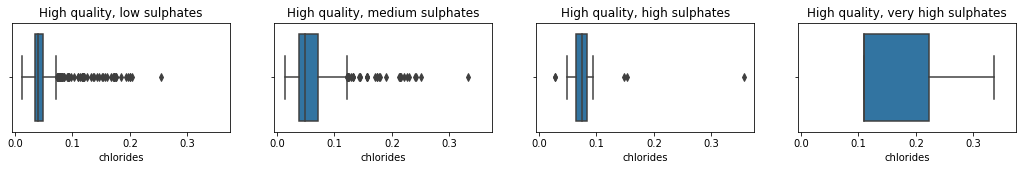

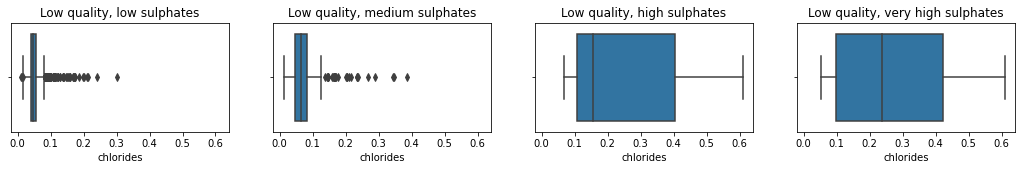

In [152]:
# load dataset 
dataset_df = pd.read_csv('JuiceQuality.csv')

## High Quality
local_df = dataset_df[['sulphates', 'chlorides', 'quality']]
high_df = local_df[local_df['quality'] == 'high']
highq_low_sulph_df = high_df[high_df['sulphates'] == "low"]
highq_medium_sulph_df = high_df[high_df['sulphates'] == "medium"]
highq_high_sulph_df = high_df[high_df['sulphates'] == "high"]
highq_very_high_sulph_df = high_df[high_df['sulphates'] == "very_high"]

## plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 2), sharex=True, sharey=True)
sns.boxplot(ax=ax1, x="chlorides", data=highq_low_sulph_df)
ax1.set_title("High quality, low sulphates")
sns.boxplot(ax=ax2, x="chlorides", data=highq_medium_sulph_df)
ax2.set_title("High quality, medium sulphates")
sns.boxplot(ax=ax3, x="chlorides", data=highq_high_sulph_df)
ax3.set_title("High quality, high sulphates")
sns.boxplot(ax=ax4, x="chlorides", data=highq_very_high_sulph_df)
ax4.set_title("High quality, very high sulphates")
plt.show()

## Low Quality
low_df = local_df[local_df['quality'] == 'low']
lowq_low_sulph_df = low_df[low_df['sulphates'] == "low"]
lowq_medium_sulph_df = low_df[low_df['sulphates'] == "medium"]
lowq_high_sulph_df = low_df[low_df['sulphates'] == "high"]
lowq_very_high_sulph_df = low_df[low_df['sulphates'] == "very_high"]

## plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 2), sharex=True, sharey=True)
sns.boxplot(ax=ax1, x="chlorides", data=lowq_low_sulph_df)
ax1.set_title("Low quality, low sulphates")
sns.boxplot(ax=ax2, x="chlorides", data=lowq_medium_sulph_df)
ax2.set_title("Low quality, medium sulphates")
sns.boxplot(ax=ax3, x="chlorides", data=lowq_high_sulph_df)
ax3.set_title("Low quality, high sulphates")
sns.boxplot(ax=ax4, x="chlorides", data=lowq_very_high_sulph_df)
ax4.set_title("Low quality, very high sulphates")
plt.show()


-------- REPORT ----------

به طور کلی از آنجایی که در داده های ما تعداد کمی نوشدنی سولفات بالا، دارند، به اطمینان نمیتوان حکمی راجع به آنان صادر کرد، در دو مورد سمت راست تصاویر بالا شاهد پراکندگدی بالایی هستیم، پس یعنی رابطه معنا داری بین سولفات و کلراید در این حالت وجود ندارد 

اما کلراید این نوشیدنی ها بر اساس سولفات کم، مقدار متمرکزی دارد که نشان از وابتسگی بالا بین سولفات و کلراید در مقادیر سولفات پایین دارد.

سولفات نوشیدنی اگر کم یا مدیوم باشد نمیتوان تشخیص داد نوشیدنی کیفیت بالا دارد یا کم چون نمودار مشابهی دارند

اما سولفات زیاد یا خیلی زیاد می تواند شهودی به ما در جهت تمایز این دو نوع نوشیدنی بدهد چون میانگین آنها اختلاف دارد پس اگر سولفات زیاد داشته باشیم و کلراید آن را بدانیم می توانیم با احتمال بهتری تشخیص دهیم از کدام نوع نوشیدنی است، 

-------- REPORT ----------

Plot Histogram for "free sulphor dioxide" for hight and low quailty with the distinction of juice type. 

Text(0.5, 1.0, 'Low quality, lemon juice')

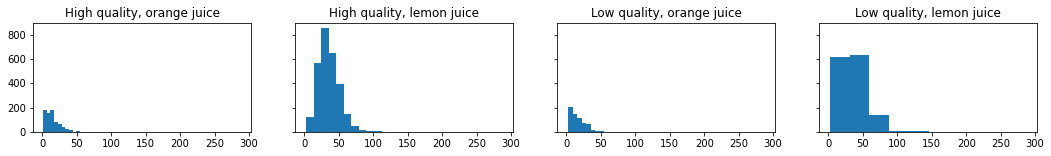

In [153]:
# load dataset 
dataset_df = pd.read_csv('JuiceQuality.csv')

local_df = dataset_df[['free sulfur dioxide', 'quality', 'Type']]
high_df = local_df[local_df['quality'] == 'high']
low_df = local_df[local_df['quality'] == 'low']

highq_orange_df = high_df[high_df['Type'] == "Orange_Juice"]
highq_lemon_df = high_df[high_df['Type'] == "Lemon_Juice"]
lowq_orange_df = low_df[low_df['Type'] == "Orange_Juice"]
lowq_lemon_df = low_df[low_df['Type'] == "Lemon_Juice"]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 2), sharex=True, sharey=True)
ax1.hist(x=highq_orange_df['free sulfur dioxide'])
ax1.set_title("High quality, orange juice")
ax2.hist(x=highq_lemon_df['free sulfur dioxide'])
ax2.set_title("High quality, lemon juice")
ax3.hist(x=lowq_orange_df['free sulfur dioxide'])
ax3.set_title("Low quality, orange juice")
ax4.hist(x=lowq_lemon_df['free sulfur dioxide'])
ax4.set_title("Low quality, lemon juice")

-------- REPORT ----------

اینجا شاهد تفاوت های جالبی هستیم

مقدار این فیچر در نوشیدنی باکیفیت لیمو از پرتقال خیلی بیشتر است

از طرفی تفاوت چشم گیری بین نوشیدنی باکیفیت و کم کیفیت پرتقال نیست

اما اگر این فیچر در یک نوشیدنی لیمو، مقدار خیلی زیادی داشت، به احتمال زیاد نوشیدنی باکفیت خواهد بود اما اگر مقدار نسبتا زیادی داشت، احتمالا کم کیفیت خواهد بود

-------- REPORT ----------

Plot heat map for the first 12 column. Compare the correlation between features. 

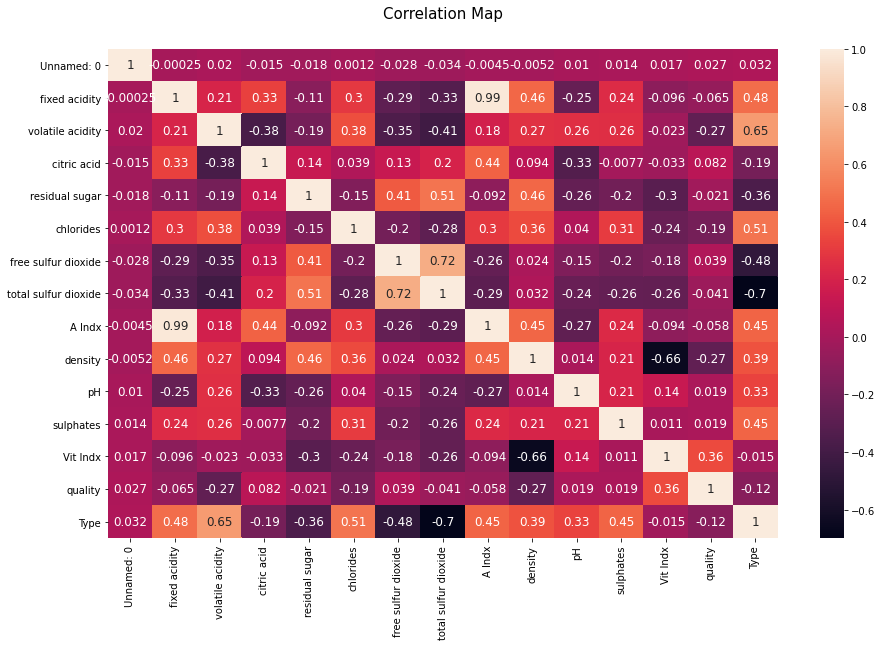

In [154]:
#sns.heatmap
# load dataset 
dataset_df = pd.read_csv('JuiceQuality.csv')

# quantitication!
dataset_df['quality'] = dataset_df['quality'].map({'low':0, 'high':1})
dataset_df['residual sugar'] = dataset_df['residual sugar'].map({'very_low':-2, 'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['sulphates'] = dataset_df['sulphates'].map({'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['Vit Indx'] = dataset_df['Vit Indx'].map({'very_low':-2, 'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['Type'] = dataset_df['Type'].map({'Lemon_Juice':0, 'Orange_Juice':1})

# Correlation
fig = plt.figure()
Corr = dataset_df.corr()
fig.set_size_inches(15, 9, forward = True)
sns.heatmap(Corr, square=False, annot=True, linecolor='white', annot_kws={'fontsize':12 })
plt.title('Correlation Map', y=1.05, size=15)
plt.autoscale()
plt.show()


-------- REPORT ----------

ویژگی هایی که قدرمطلق همبستگی آن ها نزدیک به یک باشد، وابستگی بیشتری دارند

- A Indx , fixed acidity

- residual sugar, total sulfur dioxide

- type, total sulfur dioxide

- type, chlorides

- type, volatile acidity

- Vit Indx , density



می توان ویژگی هایی که همبستگی خیلی کمی با مقدار هدف ما یعنی کیفیت دارند را حذف کرد مثلا پی اچ یا سولفور اکسید آزاد 

هم چنین یکی از  دو ویژگی که با هم همبستگی بالایی دارند را می شود حذف کرد چون وجود هر دو اطلاعات جدیدی به ما نمیدهد.


-------- REPORT ----------

## Part 3 AdaBoost
Use a 5-fold cross validaiton to tune parameters. Utilize DecisionTreeClassifier for the base classifier.
 max_depth must be chosen from {1,3,5} and n_estimators are chosen from {10,50,100,200}. 

In [181]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# load dataset 
dataset_df = pd.read_csv('JuiceQuality.csv')

# preprocessing
dataset_df['quality'] = dataset_df['quality'].map({'low':0, 'high':1})
dataset_df['residual sugar'] = dataset_df['residual sugar'].map({'very_low':-2, 'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['sulphates'] = dataset_df['sulphates'].map({'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['Vit Indx'] = dataset_df['Vit Indx'].map({'very_low':-2, 'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['Type'] = dataset_df['Type'].map({'Lemon_Juice':0, 'Orange_Juice':1})
dataset_df.drop(['Unnamed: 0'] , inplace=True, axis=1)
dataset_df.dropna(inplace=True)

# Splitting
X = dataset_df.iloc[:, :12]
y = dataset_df.iloc[:, 12]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Find optimal params
max_depth = [1,3,5]
n_estimators = [10,50,100,200]

dict_score = {}
for n in [10,50,100,200]:
    for j in [1,3,5]:
        model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=j), n_estimators=n)
        cvs = cross_val_score(model, X_train, y_train, cv=5)
        dict_score['{},{}'.format(n, j)] = cvs.max()
print(dict_score)


{'10,1': 0.7397260273972602, '10,3': 0.761252446183953, '10,5': 0.7671232876712328, '50,1': 0.7592954990215264, '50,3': 0.7397260273972602, '50,5': 0.7592954990215264, '100,1': 0.7514677103718199, '100,3': 0.7455968688845401, '100,5': 0.7729941291585127, '200,1': 0.7495107632093934, '200,3': 0.7632093933463796, '200,5': 0.7827788649706457}


-------- REPORT ----------

optimal point: 200, 5

-------- REPORT ----------

Report F1 score, accuracy and Confusion matrix for the optimum paramters. 

In [186]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Model Trainng
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=200)
model.fit(X_train, y_train)

# Scores
y_predict = model.predict(X_train)
print('--- Train Data ')
print("The accuracy score: {}".format(accuracy_score(y_train, y_predict)))
print("The f1 score: {}".format(f1_score(y_train, y_predict)))
print("The confusion matrix: \n {} \n\n".format(confusion_matrix(y_train, y_predict)))

y_predict = model.predict(X_test)
print('--- Test Data ')
acs = accuracy_score(y_test,y_predict)
f1s = f1_score(y_test,y_predict)
com = confusion_matrix(y_test,y_predict)
print("The accuracy score: {}".format(accuracy_score(y_test, y_predict)))
print("The f1 score: {}".format(f1_score(y_test, y_predict)))
print("The confusion matrix: \n {}".format(confusion_matrix(y_test, y_predict)))



--- Train Data 
The accuracy score: 1.0
The f1 score: 1.0
The confusion matrix: 
 [[ 948    0]
 [   0 1607]] 


--- Test Data 
The accuracy score: 0.7777777777777778
The f1 score: 0.8321513002364066
The confusion matrix: 
 [[145  73]
 [ 69 352]]


Plot the two-class decision scores. Use the decision_function of you classifier. 

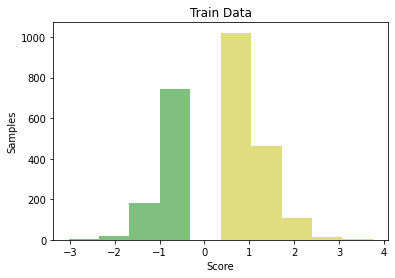

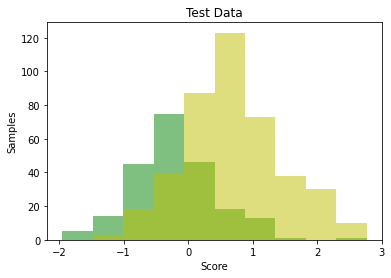

In [211]:
# model.decision_function(X)
# plt.hist()

# Train decision score
twoclass_output = model.decision_function(X_train)
plot_range = (twoclass_output.min(), twoclass_output.max())
plot_colors = "gy"
class_names = "AB"
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y_train == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5)
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Train Data')
plt.show()

# Test decision score
twoclass_output = model.decision_function(X_test)
plot_range = (twoclass_output.min(), twoclass_output.max())
plot_colors = "gy"
class_names = "AB"
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y_test == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5)
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Test Data')
plt.show()



## Part 4 (SVM)
In this part we are going to feed the preprocessed data (like previous parts) into a SVM classifier. Before that, let us try SVM on a toy dataset (2D), which illustrates two concentric circles, and draw its decision boundries. This is to get a better feeling of how SVM with a kernel function separates nonlinear data. Necessary libraries are imported below. Google them to find out how they are used.
### Plotting Decision Boundries

In [214]:
from sklearn.datasets.samples_generator import make_circles
from mlxtend.plotting import plot_decision_regions
# also add the rest of your imports here
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

X,y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=None, factor=0.5)

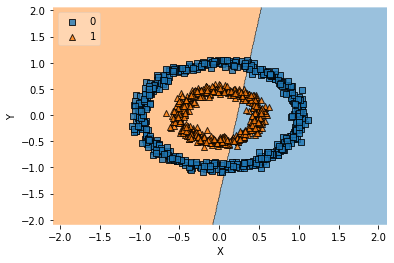

In [223]:
# SVM with Linear Kernel:
svc = SVC(kernel ='linear', C = 0.1)
svc.fit(X, y)
plot_decision_regions(X, y, clf=svc, legend=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

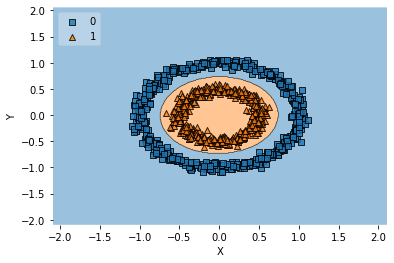

In [225]:
# SVM with RBF Kernel:
svc = SVC(kernel ='rbf', C = 0.1)
svc.fit(X, y)
plot_decision_regions(X, y, clf=svc, legend=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Hyperparameter Tuning
There are a wide variety of kernel functions like linear, poly, rbf, and sigmoid. Besides, we need to decide what the value of C (regularization parameter in soft-margin SVM) should be. In case of rbf, there is yet another parameter $\gamma$ that needs to be determined. 

$$Kernel Function \in \{linear, poly, rbf, sigmoid\}$$

$$C \in \{0.1, 1, 10, 100, 1000, 10000\}$$

$$\gamma \in \{0.001, 0.01, 0.1\}$$

Write a function (however you wish) to try all possible combinations (36 overall). Sort them based on their $F_1$ Score, and print them similar to the line below:

Print: #(rank), Classifier, $F_1$ Score, Accuracy, Precision, C, $\gamma$ (empty or NAN if not applicable)<br><br>
Draw the confusion matrix only for the best classifier. 
Please also note that 5-fold cross-validation must be used to estimate the scores.


In [258]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# load dataset 
dataset_df = pd.read_csv('JuiceQuality.csv')

# preprocessing
dataset_df['quality'] = dataset_df['quality'].map({'low':0, 'high':1})
dataset_df['residual sugar'] = dataset_df['residual sugar'].map({'very_low':-2, 'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['sulphates'] = dataset_df['sulphates'].map({'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['Vit Indx'] = dataset_df['Vit Indx'].map({'very_low':-2, 'low':-1, 'medium':0, 'high':1, 'very_high':2})
dataset_df['Type'] = dataset_df['Type'].map({'Lemon_Juice':0, 'Orange_Juice':1})
dataset_df.drop(['Unnamed: 0'] , inplace=True, axis=1)
dataset_df.dropna(inplace=True)

# Splitting
X = dataset_df.iloc[:, :12]
y = dataset_df.iloc[:, 12]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Grid Search
n_folds = 5
tuned_parameters = {'C': [0.1, 1], 'kernel': ('linear','poly','rbf','sigmoid')}
clf = GridSearchCV(SVC(), tuned_parameters, scoring = ['f1','accuracy','precision'], cv=5, refit="f1")
clf.fit(X_train, y_train)

# Result
df = pd.DataFrame(data=clf.cv_results_)
df = df[['params', 'rank_test_f1', 'mean_test_f1', 'rank_test_accuracy', 'mean_test_accuracy', 'rank_test_precision', 'mean_test_precision']]
df.sort_values(by=['rank_test_f1']).reset_index().head(8)

# Confusion Matrix
svc = SVC(kernel ='linear', C = 1)
svc.fit(X_train, y_train)
y_predict = model.predict(X_test)
print("The confusion matrix: \n {} \n\n".format(confusion_matrix(y_test, y_predict)))


The confusion matrix: 
 [[231  14]
 [ 14 380]] 




### Hard Voting Classifiers

Briefly explain what hard voting (aka majority voting) is. Then perform this classification using Logistic Regression, Decision Trees, and SVM. For more information, visit:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [259]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [261]:
clf1 = LogisticRegression()
clf2 = DecisionTreeClassifier(max_depth=5)
clf3 = SVC()
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('dt', clf2), ('sv', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
acc = accuracy_score(y_test,eclf1.predict(X_test))
print(acc)

0.7136150234741784


-------- REPORT ----------

این روش دقت مناسبی به ما نمی دهد، چرا که تعداد طبقه بندها کم می باشد، و نیز حتی ممکن است که دو طبقه بند ضعیف تر مانند رگرسیون و درخت تصمیم گیری، کار طبقه بند سوم را با رای خطابشان خراب کنند 

-------- REPORT ----------

### Convex Optimization

We are going to very briefly and easily look at how we go about solving optimization problems that we encounter when solving SVM. Here we use the same quadratic programming (use solvers.qp()) present in the theory problem set 3. Verify your theoretical solutions with Python code.

https://cvxopt.org/


$$min\hspace{3mm} J = (x_1-6)^2+(x_2-6)^2$$

$$s.\hspace{1mm} to \hspace{3mm}2 x_1+4 x_2 \leq 28$$

$$5 x_1 + 5 x_2 \leq 50$$

$$x_1 \leq 8$$

$$x_2 \leq 6$$

$$x_1 \geq 0$$

$$x_2 \geq 0$$

In [226]:
from cvxopt import matrix, solvers
P = matrix([[2.0,0.0],[0.0,2.0]])
q = matrix([-12.0,-12.0])
G = matrix([[1.0,1.0,1.0,0.0,-1.0,0.0],[2.0,1.0,0.0,1.0,0.0,-1.0]])
h = matrix([14.0,10.0,8.0,6.0,0.0,0.0])
sol = solvers.qp(P,q,G,h)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -6.8978e+01 -9.8373e+01  5e+01  1e-01  1e+00
 1: -6.7433e+01 -7.1460e+01  4e+00  1e-16  5e-17
 2: -6.8778e+01 -6.9262e+01  5e-01  1e-16  8e-17
 3: -6.8799e+01 -6.8809e+01  1e-02  1e-16  5e-16
 4: -6.8800e+01 -6.8800e+01  1e-04  1e-16  2e-16
 5: -6.8800e+01 -6.8800e+01  1e-06  1e-16  9e-17
Optimal solution found.
[ 5.20e+00]
[ 4.40e+00]



$$min\hspace{3mm} J = x_2^2$$

$$s.\hspace{1mm} to \hspace{3mm}x_1+x_2 \leq 10$$

$$x_1 \geq 0$$

$$x_1 \leq 5$$

In [222]:
P = matrix([[0.0,0.0],[0.0,1.0]])
q = matrix([0.0,0.0])
G = matrix([[1.0,-1.0,1.0],[1.0,0.0,0.0]])
h = matrix([10.0,0.0,5.0])
sol = solvers.qp(P,q,G,h)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  4.5000e+00 -9.5000e+00  1e+01  0e+00  7e+00
 1:  2.8500e-02 -6.6784e-01  7e-01  1e-16  4e-01
 2:  2.8222e-06 -7.2586e-03  7e-03  1e-16  4e-03
 3:  2.8222e-10 -7.2619e-05  7e-05  8e-17  4e-05
 4:  2.8222e-14 -7.2620e-07  7e-07  2e-16  4e-07
 5:  2.8222e-18 -7.2620e-09  7e-09  1e-16  4e-09
Optimal solution found.
[ 4.20e+00]
[ 2.38e-09]



Thank you!

![alt text](https://drive.google.com/uc?export=view&id=1Sgj1xm4M9fkcxA7nRYU_TNB1qjzgQD-T)